In [50]:
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [51]:
import pandas as pd

In [52]:
import numpy as np

In [191]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [54]:
import torch
from sentence_transformers import SentenceTransformer
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Model is loaded on:", model.device)

/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model is loaded on: mps:0


In [55]:
filename = 'AG_news_dataset/train.csv'
df = pd.read_csv(filename)
descriptions = np.array(df['Description'])
categories = np.array(df['Class Index'] - 1) # This -1 is CRUCIAL because classes must be 0...N-1 where N is number of classes.
descriptions, categories = shuffle(descriptions, categories, random_state=0)


In [56]:
embeddings = model.encode(descriptions)

In [8]:
# pca = PCA(n_components=50)
# embeddings = pca.fit_transform(embeddings)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embeddings, categories, test_size=0.2, random_state=42)

In [311]:
inputs = tf.keras.Input(shape=(384,))
x = layers.Dense(100, activation='relu')(inputs)
x = layers.Dense(70, activation='relu')(x)
x = layers.Dense(40, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 100)            │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 70)             │         7,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 40)             │         2,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 4)              │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,574 (189.74 KB)

 Trainable params: 48,574 (189.74 KB)

 Non-trainable params: 0 (0.00 B)

In [312]:
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [313]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 672us/step - accuracy: 0.7725 - loss: 0.7092 - val_accuracy: 0.8885 - val_loss: 0.3277
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - accuracy: 0.8909 - loss: 0.3232 - val_accuracy: 0.8920 - val_loss: 0.3113
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 672us/step - accuracy: 0.8942 - loss: 0.3086 - val_accuracy: 0.8959 - val_loss: 0.3025
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - accuracy: 0.8980 - loss: 0.2940 - val_accuracy: 0.8980 - val_loss: 0.2948
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - accuracy: 0.8996 - loss: 0.2876 - val_accuracy: 0.8992 - val_loss: 0.2890
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 687us/step - accuracy: 0.9042 - loss: 0.2755 - val_accuracy: 0.9012 - val_loss: 0.2841
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - accuracy: 0.9079 - loss: 0.2658 - val_accuracy: 0.9027 - val_loss: 0.2802
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - accuracy: 0.9106 -

In [291]:
y_val_predict_probs = model.predict(X_val)

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


In [292]:
y_val_predict = np.argmax(y_val_predict_probs, axis=1)

In [293]:
print('val accuracy', sum(y_val_predict == y_val) / len(y_val))

val accuracy 0.9137083333333333


In [314]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

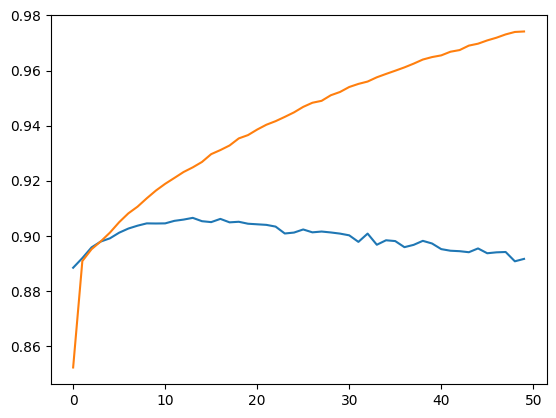

In [315]:
import  matplotlib.pyplot as plt
plt.plot(val_accuracy)
plt.plot(train_accuracy)